# Simulating a Quantum Random Walk

Code implementation of a Hadamard walk using Qiskit

In [1]:
import numpy as np
from qiskit import(
    QuantumCircuit,
    execute,
    Aer)
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt 

# Use Aer's qasm_simulator
simulator = Aer.get_backend('qasm_simulator')

## Simulation Parameters

- Set `n` to be the number of bits used to represent the state.
- Set the boolean `make_symmetric` to set whether or not we should start with the state $|00\rangle$ (`False`) or $\frac{1}{\sqrt{2}}\left(|0\rangle+i |1\rangle\right)\otimes |0\rangle$ (`True`). As we discuss in our report, this causes a skewed or symmetric distribution.
- Set `num_steps` to be the number of steps in the walk. If this exceeds $2^{n-1}-1$, it will be set to this value instead.

In [2]:
n = 7 # number of bits for state

# note: starts to take a while for n>5
num_qubits = n + 1 # 1 additional bit for coin flip

make_symmetric = True

num_steps = 64

## Increment and Decrement Gates

Here we define the increment and decrement translations to be used for the simulation

In [3]:
increment_circuit = QuantumCircuit(n, name='add1')
for i in range(n - 1):
    increment_circuit.mcx([j for j in range(n - 1 - i)], n - 1 - i)
increment_circuit.x(0)

increment_circuit.draw()

┌───┐
q_0: ──■────■────■────■────■────■──┤ X ├
       │    │    │    │    │  ┌─┴─┐└───┘
q_1: ──■────■────■────■────■──┤ X ├─────
       │    │    │    │  ┌─┴─┐└───┘     
q_2: ──■────■────■────■──┤ X ├──────────
       │    │    │  ┌─┴─┐└───┘          
q_3: ──■────■────■──┤ X ├───────────────
       │    │  ┌─┴─┐└───┘               
q_4: ──■────■──┤ X ├────────────────────
       │  ┌─┴─┐└───┘                    
q_5: ──■──┤ X ├─────────────────────────
     ┌─┴─┐└───┘                         
q_6: ┤ X ├──────────────────────────────
     └───┘

In [4]:
increment_gate = increment_circuit.to_gate()
controlled_increment_gate = increment_gate.control()

In [5]:
decrement_circuit = QuantumCircuit(n, name='sub1')
decrement_circuit.x(0)
for i in range(n - 1):
    decrement_circuit.mcx([j for j in range(i+1)], i+1)

decrement_circuit.draw()

┌───┐                              
q_0: ┤ X ├──■────■────■────■────■────■──
     └───┘┌─┴─┐  │    │    │    │    │  
q_1: ─────┤ X ├──■────■────■────■────■──
          └───┘┌─┴─┐  │    │    │    │  
q_2: ──────────┤ X ├──■────■────■────■──
               └───┘┌─┴─┐  │    │    │  
q_3: ───────────────┤ X ├──■────■────■──
                    └───┘┌─┴─┐  │    │  
q_4: ────────────────────┤ X ├──■────■──
                         └───┘┌─┴─┐  │  
q_5: ─────────────────────────┤ X ├──■──
                              └───┘┌─┴─┐
q_6: ──────────────────────────────┤ X ├
                                   └───┘

In [6]:
decrement_circuit = decrement_circuit.to_gate()
controlled_decrement_gate = decrement_circuit.control()

## Create Circuit

This code creates the circuit for the walk specified by the parameters above. Uncomment the final line to see a visualization, though this will be large and visually confusing for large `num_steps`.

In [7]:
num_steps = min(num_steps, 2**(n-1) - 1)
# should only do at most 2^(n-1) - 1 steps (right bound for signed integer)

trials = 1000

qc = QuantumCircuit(num_qubits, n)

# first qubit is coin flip
# other qubits are state/position qubits, with one bit for sign (leftmost bit)

if make_symmetric:
    # for symmetric distribution
    qc.h(0)
    qc.s(0)

for i in range(num_steps):
    qc.h(0)
    # controlled increment
    qc.append(controlled_increment_gate, [j for j in range(num_qubits)])
    
    
    # controlled decrement
    qc.x(0)
    qc.append(controlled_decrement_gate, [j for j in range(num_qubits)])
    qc.x(0)
    
# qc.draw()

## Run Simulation

Uses the Qiskit Aer simulator to simulate the walk. Prints the probability distribution as well as generates a plot.

In [8]:
# Map the quantum measurement to the classical bits
qc.measure([i+1 for i in range(n)], [i for i in range(n)])

# Execute the circuit on the qasm simulator
job = execute(qc, simulator, shots=trials)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(qc)
print("\nTotal counts (signed binary representation):", counts)

def to_decimal(num):
    if num[0]=='0':
        return int(num, 2)
    else:
        return int(num, 2) - (1 << len(num))

distribution = {}
for x in counts:
    distribution[to_decimal(x)] = counts[x]/trials

print("\nStates and Probabilities (decimal representation):", distribution)


Total counts (signed binary representation): {'0000001': 13, '0010001': 14, '0010011': 12, '0010101': 16, '0010111': 8, '0011001': 17, '0011011': 24, '0011101': 21, '0011111': 9, '0100001': 28, '0100011': 9, '0100101': 49, '0100111': 4, '0101001': 66, '0101011': 107, '0101101': 32, '0101111': 2, '0000011': 9, '0110001': 4, '0000101': 7, '1010001': 5, '1010011': 39, '1010101': 88, '1010111': 65, '1011001': 7, '1011011': 55, '1011101': 9, '1011111': 28, '1100001': 20, '1100011': 15, '1100101': 16, '1100111': 9, '1101001': 16, '1101011': 20, '1101101': 10, '1101111': 13, '0000111': 10, '1110001': 9, '1110011': 9, '1110101': 16, '1110111': 11, '1111001': 8, '1111011': 9, '1111101': 9, '1111111': 12, '0001001': 16, '0001011': 8, '0001101': 8, '0001111': 9}

States and Probabilities (decimal representation): {1: 0.013, 17: 0.014, 19: 0.012, 21: 0.016, 23: 0.008, 25: 0.017, 27: 0.024, 29: 0.021, 31: 0.009, 33: 0.028, 35: 0.009, 37: 0.049, 39: 0.004, 41: 0.066, 43: 0.107, 45: 0.032, 47: 0.002

<BarContainer object of 49 artists>

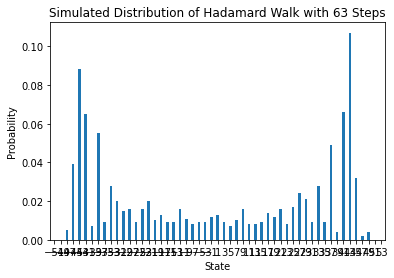

In [9]:
plt.xlabel("State")
if num_steps % 2 == 1:
    plt.xticks([2*i+1 for i in range(-(num_steps + 1)//2, (num_steps + 1)//2)])
else:
    plt.xticks([2*i for i in range(-num_steps//2, num_steps//2+1)])
plt.ylabel("Probability")
plt.title("Simulated Distribution of Hadamard Walk with %s Steps" % num_steps)
plt.bar(list(distribution.keys()), list(distribution.values()))